
# Home Credit - Default Risk Classification 
https://www.kaggle.com/c/home-credit-default-risk/overview

### Goal  
   - Predict if a bank should accept or reject a loan application of an individual (binary classification)
   - Achieve an acceptable AUC score (0.75+).
   - Perform threshold optimization. 


### Overview:  
   - Will perform manual feature engineering
   - Will evaluate different algorithms using AUC score
   - Will use LGBM for the classification
   - Will perform parameter tuning using RandomSearch
 
### Notebook Structure :
    
 - Exploratory data analysis
 - Handle Missing Values
 - Handle Categorical Features
 - Evaluate algorithms  
    - LGBM
    - Tree
    - Random Forest
   - Feature importance
 - Threshold optimization （G-MEAN)
 
### Learning Material: 
 
#### @Will Koehrsen: https://www.kaggle.com/willkoehrsen/home-credit-default-risk-feature-tools
- Learned a lot about EDA and feature engineering from his notebook.

#### @Misha Lisovyi: https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761
- The hyperparameter tuning skills are learned from here. Good tutorial.

#### @Jason Brownlee: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
- Great article about parameter tuning for imbalanced classification.

#### Note: Some of the codes here are learned from the aboving three notebooks.


### ----Content Starts here-----

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Define some functions that could help us operate faster. 

In [2]:
def value_counts(cols):
    value_counts = cols.value_counts(dropna = False )
    return value_counts

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
def check_null(df):
    all_cols = df.isnull().sum().sort_values(ascending = False)
    null_cols = all_cols[all_cols > 0]
    return null_cols

def check_null_percent(df):
    null_cols = check_null(df)
    null_percent = ((null_cols / len(df))* 100).round(2)
    return null_percent

def index_to_list(df):
    index_to_list = df.index.to_list()
    return index_to_list

def drop_cols(df, cols):
    df = df.drop(cols, axis = 1)
    return df

def drop_threshold_cols(df, threshold):
    null_percent = check_null_percent(df)
    over_threshold_col = null_percent[null_percent > threshold]
    over_threshold_col = index_to_list(over_threshold_col)
    df = df.drop(over_threshold_col, axis = 1)
    return df

def fill_cols_zero(df, cols):
    df[cols] = df[cols].fillna(value=0)
    return df

def fill_cols_mode(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

def fill_cols_mean(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].mean())
    return df

def check_start(df, cols, vals):
    lst = []
    for col in cols:
        for val in vals:
            if col.startswith(val):
                lst.append(col)
    return lst

def check_end(df, cols, vals):
    lst = []
    for col in cols:
        for val in vals:
            if col.endswith(val):
                lst.append(col)
    return lst

def return_cat_cols(df):
    cat_cols = df.select_dtypes(include='object').columns.to_list()
    return cat_cols

def check_cat_cols(df):
    cat_cols = df.select_dtypes(include='object').columns.to_list()
    for col in cat_cols:
        print('{} has {} levels\n'.format(col, len(df[col].value_counts(ascending=True))))
    

In [3]:
path = 'C:\\Users\\ron.luo\\Documents\\Default Risk'
os.chdir(path)

In [4]:
raw_file ='application_train.csv'
test_file = 'application_test.csv'
source = pd.read_csv(raw_file, header = 0, index_col=False, engine='python')
source_test = pd.read_csv(test_file, header = 0, index_col=False, engine='python')

In [5]:
df = source.copy()

## EDA

#### Target Class

This is an imbalanced dataset. The ratio of class 1 and class 0 looks like 1:10;

<AxesSubplot:xlabel='TARGET', ylabel='count'>

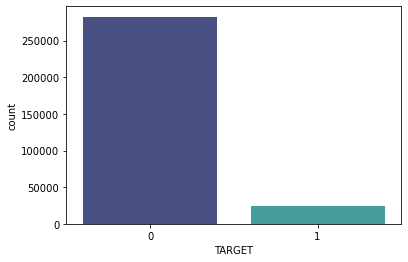

In [6]:
sns.countplot(data=df, x='TARGET', palette='mako')

#### Missing Values

From the table below, we saw that some of the features have a high percentage of missing value.   
We are going to use multivariate imputation to fill the missing values in the upcoming part.

In [7]:
missing_values_table(df)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


#### Distribution of continuous values.
_The cell below is comment out. Its purpose is to look at the distribution of each continuous feature group by Target._

In [8]:
# ncols = 3
# nrows = 21

# ## Draw a graph with 3 cols x 21 rows and size of 40 x 250
# fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize = (40,250))  

# for row in range(nrows):
#     for col in range(ncols):
#         ax = axs[row][col]
#         i = row*ncols + col  #### Go over all the index
        
#         if i < len(null_list) and df[null_list[i]].dtype != 'object':   ### Check if a column is categorical
#             sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
#                 null_list[i]], color = 'orange', shade = True, label = 'Class 1', ax = ax, bw_adjust=3)
#             sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
#                        null_list[i]], shade = True, color = 'blueviolet', label = 'Class 0', ax = ax, bw_adjust=5)
#             ax.set_title('{}'.format(null_dict[null_list[i]]))

By eyeballing the distribution of each continuous variable, we see three of them are very different - **'EXT_SOURCE_1'** and **'EXT_SOURCE_2'**, **'EXT_SOURCE_3'**.     


(Turned out that they are important features at the end of this notebook)

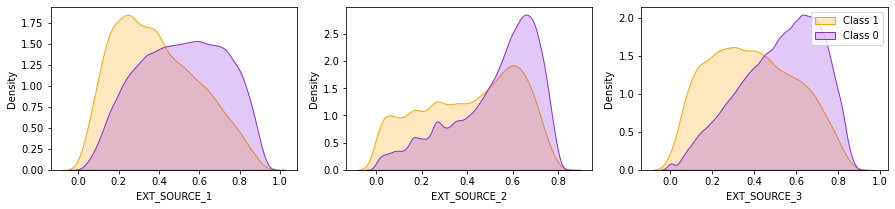

In [9]:

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize = (15,3))

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
            'EXT_SOURCE_1'], color = 'orange', shade = True, label = 'Class 1', ax = ax1)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
            'EXT_SOURCE_1'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax1)


sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_2'], color = 'orange', shade = True, label = 'Class 1', ax = ax2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_2'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_3'], color = 'orange', shade = True, label = 'Class 1', ax = ax3)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_3'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax3)

plt.legend()

#### Interesting numbers among the features

Looking at the distribution of applicant’s annual income, turn out that the distribution is extremely imbalanced. This graph told us that that are some extreme values in the applicant's annual income. The boxplot below showed us the similar information: the outliner is far away from most of the people.

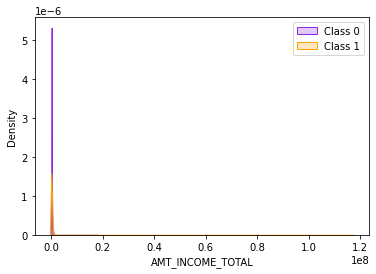

In [10]:
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'AMT_INCOME_TOTAL'], color = 'blueviolet', shade = True, label = 'Class 0', bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'AMT_INCOME_TOTAL'], color = 'orange', shade = True, label = 'Class 1', bw_adjust=2)
plt.legend()

**[DAYS_BIRTH]** lookos like indicate the days how manys days an applicant has been born. We need to convert it to **[Age]**, then further into **[Age_Group]**

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='Density'>

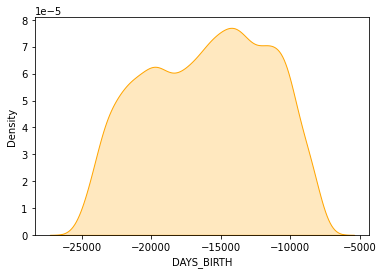

In [11]:
sns.kdeplot(data=df, x=df['DAYS_BIRTH'], 
     color = 'orange', shade = True,  bw_adjust=2)

In [12]:
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH'])
df['AGE'] = (df['DAYS_BIRTH'] // 365)
bins = [10,20,30,40,50,60,70,80,90]
labels = ["(10,20)","(20,30)","(30,40)", "(40,50)","(50,60)","(60,70)","(70,80)","(80,90)"]
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels)

In [13]:
df = df.drop(['DAYS_BIRTH'], axis=1)

It turned out that the default risk decreases by **[Age_Group]**.

<AxesSubplot:xlabel='levels', ylabel='%'>

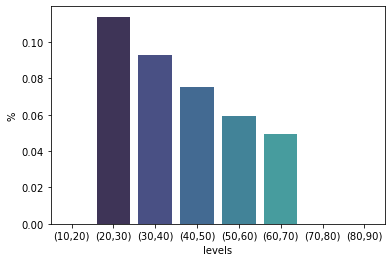

In [14]:
target_count = df[(df['TARGET'] == 1)]['AGE_GROUP'].value_counts()  ## AGE_GROUP Value count when Target = 1
feature_count = df['AGE_GROUP'].value_counts()  ##AGE_GROUP count in the entire dataset
ratio = target_count / feature_count
ratio = ratio.to_frame().reset_index()
ratio = ratio.rename(columns= {'index': 'levels', 'AGE_GROUP': '%'})
sns.barplot(data = ratio, x = 'levels', y = '%', palette = 'mako')

Same pattern could be seen by the feature **['REGION_RATING_CLIENT_W_CITY']**. Applicant living in the city rated '3' is more likely to default a loan.

<AxesSubplot:xlabel='levels', ylabel='%'>

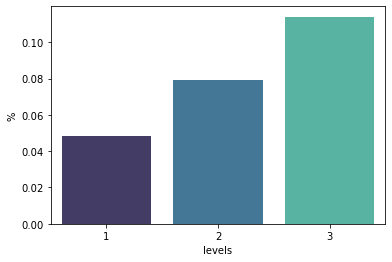

In [15]:
target_count = df[(df['TARGET'] == 1)]['REGION_RATING_CLIENT_W_CITY'].value_counts()  ## AGE_GROUP Value count when Target = 1
feature_count = df['REGION_RATING_CLIENT_W_CITY'].value_counts()  ##AGE_GROUP count in the entire dataset
ratio = target_count / feature_count
ratio = ratio.to_frame().reset_index()
ratio = ratio.rename(columns= {'index': 'levels', 'REGION_RATING_CLIENT_W_CITY': '%'})
sns.barplot(data = ratio, x = 'levels', y = '%', palette = 'mako')

A reversed trend can be seen in the **[EDUCATION_TYPE]**. People with a higher education type will be a safe bet.

<AxesSubplot:xlabel='levels', ylabel='%'>

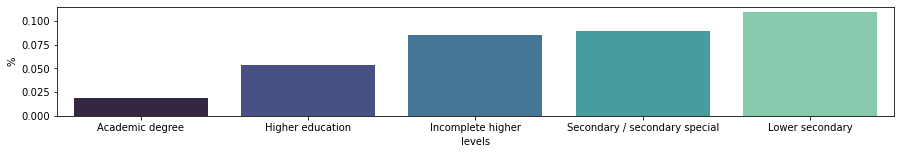

In [16]:
target_count = df[(df['TARGET'] == 1)]['NAME_EDUCATION_TYPE'].value_counts()  ## AGE_GROUP Value count when Target = 1
feature_count = df['NAME_EDUCATION_TYPE'].value_counts()  ##AGE_GROUP count in the entire dataset
fig, ax = plt.subplots(figsize = (15, 2))
ratio = (target_count / feature_count).sort_values(ascending = True)
ratio = ratio.to_frame().reset_index()
ratio = ratio.rename(columns= {'index': 'levels', 'NAME_EDUCATION_TYPE': '%'})
sns.barplot(data = ratio, x = 'levels', y = '%', palette = 'mako')

Looking at **'DAY_EMPLOYED'**, the distribution is strange. A lot of people have a value of **365243**, but other than this all people have a negative lower than **-200**.

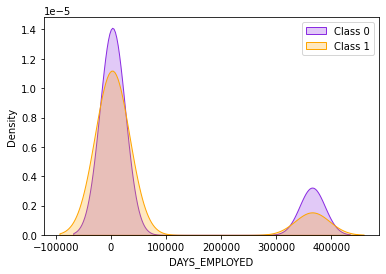

In [17]:
df['DAYS_EMPLOYED'] = abs(df['DAYS_EMPLOYED'])
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'DAYS_EMPLOYED'], color = 'blueviolet', shade = True, label = 'Class 0', legend=True, bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'DAYS_EMPLOYED'], color = 'orange', shade = True, label = 'Class 1', legend=True, bw_adjust=2)
plt.legend()

In [18]:
df['DAYS_EMPLOYED_CLASS'] = np.where(df['DAYS_EMPLOYED']!= 365243, 1, 0)

<AxesSubplot:xlabel='levels', ylabel='%'>

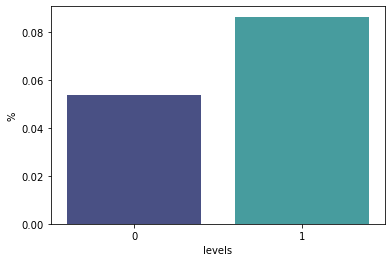

In [19]:
target_count = df[(df['TARGET'] == 1)]['DAYS_EMPLOYED_CLASS'].value_counts()  ## AGE_GROUP Value count when Target = 1
feature_count = df['DAYS_EMPLOYED_CLASS'].value_counts()  ##AGE_GROUP count in the entire dataset
ratio = target_count / feature_count
ratio = ratio.to_frame().reset_index()
ratio = ratio.rename(columns= {'index': 'levels', 'DAYS_EMPLOYED_CLASS': '%'})
sns.barplot(data = ratio, x = 'levels', y = '%', palette = 'mako')

By using the barplot, it turned out that those having an extreme value are more likely to default a loan. 

### 1.3 Feature Enginnering

From EDA, we have already created two new features: **['AGE_GROUP']** and **['DAYS_EMPLOYED_CLASS']**. And we are going to create more in this part. 

**[Total Document Received]**: columns start with 'FLAG_DOCUMENT' means if an applicant submit a document. We are going to sum these columns to get the total number of document received.

In [20]:
DOC_cols = check_start(df,df.columns,["FLAG_DOCUMENT"])
df['TOTAL_DOC'] = df[DOC_cols].sum(axis=1)

**[Total Query]**: columns start with "AMT_REQ_CREDIT_BUREAU" means how many query an applicant send. We are going to sum these as well.

In [21]:
QUERY_cols = check_start(df,df.columns,["AMT_REQ_CREDIT_BUREAU"])
df['TOTAL_QUERY'] = df[QUERY_cols].sum(axis=1)

**[Total Contact]**: we are going to sum how many contact methods the applicant provided

In [22]:
CONTACT_cols = check_end(df,df.columns,["PHONE","MOBILE","EMAIL"])
df['TOTAL_CONTACT'] = df[CONTACT_cols].sum(axis=1)

**[Social Circle Default Total]**: we are going to check the number that how many people in the applicant's social circle default the loan.

In [23]:
CIRCLE_cols =  check_end(df,df.columns,["CIRCLE"])
df['CIRCLE'] = df[CIRCLE_cols].sum(axis = 1)

### Handle Missing Values  


**Note**: though some algorhithms can handle or ignore missing values, it is in general a good idea to make your data as clean as possible.

**Fill missing values using MICE**

##### - 1.1.2 Fill each column accordingly

- Some feautes have a Null value indicating it is zero. For these features, we fill 0

In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [26]:
df_mice = df.copy()
MEDI_cols = check_end(df_mice, df_mice.columns, ['MEDI'])
AVG_cols = check_end(df_mice, df_mice.columns, ['AVG'])
CIRCLE_cols = check_end(df_mice, df_mice, ['CIRCLE'])
EXT_cols = check_start(df_mice, df_mice.columns, ['EXT'])
AMT_cols = check_start(df_mice, df_mice.columns, ['AMT'])
MODE_cols =  check_end(df_mice, df_mice.columns, ['MODE'])

In [27]:
for col in df[MODE_cols]:
    if df[col].dtypes == 'object':
        MODE_cols.remove(col)

In [28]:
All_cols = [MEDI_cols, AVG_cols, MODE_cols, CIRCLE_cols, EXT_cols, AMT_cols ]

In [29]:
df_temp = df.copy()

In [30]:
### This cell will take a while to process
for cols in All_cols:
    imp_mean = IterativeImputer(random_state=20,max_iter = 250)
    imp_mean.fit(df_mice[cols])
    df_mice_temp = imp_mean.transform(df_mice[cols])
    df_mice_temp = pd.DataFrame(df_mice_temp, columns = cols)
    df_temp[cols] = df_mice_temp

In [31]:
df = df_temp.copy()

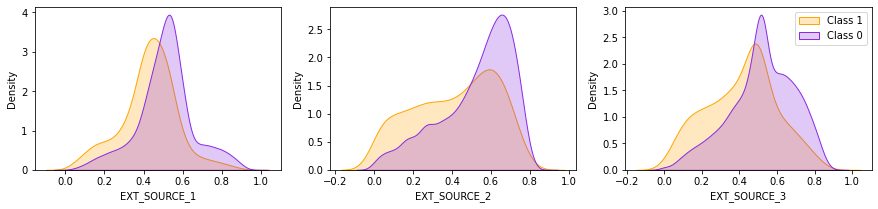

In [32]:

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize = (15,3))

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
            'EXT_SOURCE_1'], color = 'orange', shade = True, label = 'Class 1', ax = ax1, bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
            'EXT_SOURCE_1'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax1, bw_adjust=2)


sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_2'], color = 'orange', shade = True, label = 'Class 1', ax = ax2, bw_adjust=2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_2'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax2, bw_adjust=2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_3'], color = 'orange', shade = True, label = 'Class 1', ax = ax3, bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_3'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax3, bw_adjust=2)

plt.legend()

In [33]:
## The remaining columns still have missing values. We are going to drop them for now
other_cols = missing_values_table(df).index.to_list()
df = df.drop(other_cols, axis = 1)

Your selected dataframe has 128 columns.
There are 9 columns that have missing values.


#### 1.2 Handle Categorical Features

Check how many levels each categorical feature has

In [ ]:
### Comment out for test


# Based on experiement, MICE perform best when TARGET is included
# for cols in All_cols:
#     cols.append('TARGET')

In [34]:
check_cat_cols(df)

NAME_CONTRACT_TYPE has 2 levels

CODE_GENDER has 3 levels

FLAG_OWN_CAR has 2 levels

FLAG_OWN_REALTY has 2 levels

NAME_INCOME_TYPE has 8 levels

NAME_EDUCATION_TYPE has 5 levels

NAME_FAMILY_STATUS has 6 levels

NAME_HOUSING_TYPE has 6 levels

WEEKDAY_APPR_PROCESS_START has 7 levels

ORGANIZATION_TYPE has 58 levels



In [35]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['OWN_CAR'] = labelencoder.fit_transform(df['FLAG_OWN_CAR'])
df['OWN_REALTY'] = labelencoder.fit_transform(df['FLAG_OWN_REALTY'])
df['CONTRACT_TYPE'] = labelencoder.fit_transform(df['NAME_CONTRACT_TYPE'])
df['GENDER'] = labelencoder.fit_transform(df['CODE_GENDER'])
df = df.drop(['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_CONTRACT_TYPE','CODE_GENDER'], axis = 1)

In [36]:
cat_cols = df.select_dtypes(include = ['category','object']).columns.to_list()

In [37]:
df[cat_cols].isnull().sum()

NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
AGE_GROUP                     0
dtype: int64

In [38]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
cols_encoded = encoder.fit_transform(df[cat_cols])
encode_cols = encoder.get_feature_names(cat_cols)
enc_df = pd.DataFrame(cols_encoded.toarray(), columns = encode_cols )
frames = [df, enc_df]
df = pd.concat(frames, axis = 1, ignore_index=False)


In [39]:
final_df = df.drop(cat_cols, axis = 1).copy()

In [40]:
missing_values_table(df)

Your selected dataframe has 215 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Preparation before Algorithms Selection

##### Downsampling

In [41]:
ratio_num = input('Do you want to perform downsampling (int / no): ')
if ratio_num != 'no':
    ratio = int(ratio_num)
    neg = final_df[final_df['TARGET']== 0]
    target_len = len(final_df[final_df['TARGET'] == 1])
    df_neg_cut = neg[0: round((ratio * target_len))]
    df_true = final_df[final_df['TARGET']== 1]
    cut_df = pd.concat([df_neg_cut, df_true], ignore_index=True)
    df = cut_df.copy()
else:
    df = final_df.copy()

Do you want to perform downsampling (int / no): no


##### Reduce memeory usage

In [42]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [43]:
df = reduce_mem_usage(df)

Mem. usage decreased to 112.32 Mb (76.7% reduction)


### Algorithms Selection

Even though Kaggle challenge has two datasets - train, test, we can't use the test dataset because it is for submission (no target column). Therefore, for now we split this dataset into another train, test dataset. 



- Split the dataset into train / test.
- Perform Cross validation on Train Dataset
- Select the proper algo from the CV result
- Test the algo on the test dataset.
- Tune parameter to achieve target metrics. 

##### Split our dataset into train dataset and validation dataset.

In [44]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,2:].values
y = df.loc[:,'TARGET'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

##### Evaluating algorithms

In [51]:
### Algorthims
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

forest = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42) 
gauss = GaussianNB()
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 150, random_state = 42)
LGBM = LGBMClassifier(objective='binary')
dummy_clf = DummyClassifier(strategy="most_frequent")

models = [forest, gauss, tree, LGBM, dummy_clf]
models_dict = {forest:'Forest', gauss:'Gauss', tree:'tree', LGBM:'LGBM', dummy_clf : 'dummy'}

In [46]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle = True)

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score

We ran each algorithms using stratified kfold. From the graph below we see that LGBM has the highest roc_auc score.

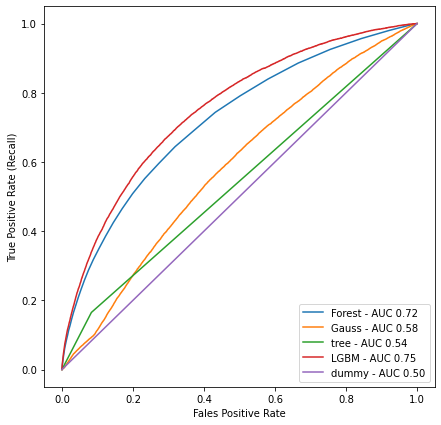

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize = (7,7)) 
for model in models:
    y_probas = cross_val_predict(model, X_train, y_train, cv=cv, method = "predict_proba")
    y_scores = y_probas[:,1]
    fpr, tpr, threshold = roc_curve(y_train, y_scores)
    roc_auc = roc_auc_score(y_train, y_scores)
    plt.plot(fpr,tpr, label = '{} - AUC {:.2f}'.format(models_dict[model], roc_auc))
    plt.xlabel('Fales Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend(loc="lower right")
plt.show()

#####  LGBM Parameter Tuning

We are going to use Random Search for parameter tuning. At the end we see that the roc_auc imporve 0.3%.

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

In [73]:
LGBM = LGBMClassifier(objective = 'binary', boosting_type= 'gbdt') ## Default LGBM without tuning
LGBM.fit(X_train,y_train)
y_probas = LGBM.predict_proba(X_test)
y_scores = y_probas[:,1]
roc_auc_raw = roc_auc_score(y_test, y_scores)

In [72]:
print('{:.3f}'.format(roc_auc_raw)) 

0.755


In [75]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'learning_rate': np.linspace(0, 1, num=100),
             'max_depth': sp_randint(0,100),
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'subsample': np.linspace(0,1,100),
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [76]:
grid = RandomizedSearchCV(LGBM, param_test,
                    verbose=0,
                    cv=3,
                    n_jobs=2,
                    scoring='roc_auc')

In [77]:
grid.fit(X_train, y_train)
best_param = grid.best_params_

In [93]:
LGBM = LGBMClassifier(objective = 'binary', boosting_type= 'gbdt',
                      colsample_bytree=best_param['colsample_bytree'],
                     learning_rate = best_param['learning_rate'],
                     max_depth = best_param['max_depth'],
                     min_child_samples = best_param['min_child_samples'],
                     min_child_weight = best_param['min_child_weight'],
                     num_leaves = best_param['num_leaves'],
                     reg_alpha = best_param['reg_alpha'],
                     reg_lambda = best_param['reg_lambda'],
                     subsample = best_param['subsample'])

In [94]:
LGBM.fit(X_train,y_train)
y_probas = LGBM.predict_proba(X_test)
y_scores = y_probas[:,1]
roc_auc = roc_auc_score(y_test, y_scores)

In [95]:
print('{:.3f}'.format(roc_auc)) 

0.758


#### Feautre Importance

Tree-based model comes with feature importance method, we can take a look at this.

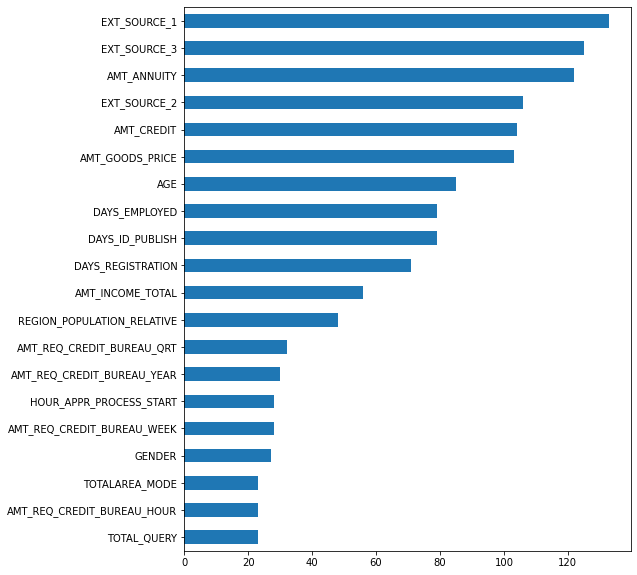

In [60]:
feat_imp = pd.Series(LGBM.feature_importances_, index=final_df.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10)).invert_yaxis()

#### G-MEAN

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity. We will use this metric for our throshold optimization.

G-Mean = sqrt(Sensitivity * Specificity)

Best Threshold=0.078842, G-Mean=0.693


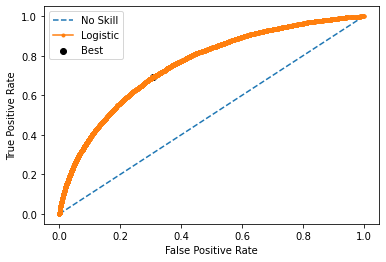

In [97]:
from numpy import sqrt
from numpy import argmax
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [98]:
gmean_threshold = thresholds[ix]

##### Here is how our model works eventually. Well, it is not a perfect model...

##### However it perform acceptably in my opinion :D

##### It can catch 68% of all the positive class.



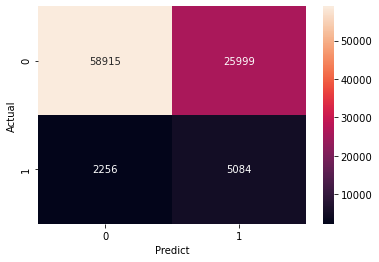

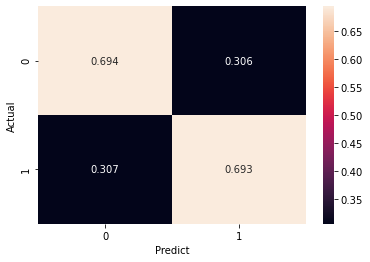

In [100]:
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

y_prob_tf = np.where(y_scores>=gmean_threshold,1,0)
cm = confusion_matrix(y_test, y_prob_tf)

sns.heatmap(cm, annot=True, fmt="g")
plt.ylabel('Actual')
plt.xlabel('Predict')
plt.show()

normalized_cm = normalize(cm, norm="l1")
sns.heatmap(normalized_cm , annot=True, fmt=".3g")
plt.ylabel('Actual')
plt.xlabel('Predict')
plt.show()

# _Pro & Cons for different algorithms_

Source: https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6

### SVM (Support Vector Machine)
- Pros
  1. Performs well in Higher dimension. In real world there are infinite dimensions (and not just 2D and 3D). For instance image data, gene data, medical data etc. has higher dimensions and SVM is useful in that. Basically when the number of features/columns are higher, SVM does well
  2. Best algorithm when classes are separable. (when instances of both the classes can be easily separated either by a straight line or non-linearly). 
  3. Outliers have less impact.
  4. SVM is suited for extreme case binary classification.  

- Cons:
    1. Slow: For larger dataset, it requires a large amount of time to process.
    2. Poor performance with Overlapped classes.
    3. Selecting appropriate hyperparameters is important: That will allow for sufficient generalization performance.
    4. Selecting the appropriate kernel function can be tricky.  
    
Applications:
Bag of words application(many features and columns), speech recognition data, classification of images(non-linear data), medical analytics(non linear data), text classification(many features)


### Naive Bayes
 - Pros
    1. Real time predictions: It is very fast and can be used in real time.
    2. Scalable with Large datasets
    3. Insensitive to irrelevant features.
    4. Multi class prediction is effectively done in Naive Bayes
    5. Good performance with high dimensional data(no. of features is large)
 - Cons
    1. Independence of features does not hold: The fundamental Naive Bayes assumption is that each feature makes an independent and equal contribution to the outcome. However this condition is not met most of the times.
    2. Bad estimator: Probability outputs from predict_proba are not to be taken too seriously.
    3. Training data should represent population well: If you have no occurrences of a class label and a certain attribute value together (e.g. class=”No”, shape=”Overcast “) then the posterior probability will be zero. So if the training data is not representative of the population, Naive bayes does not work well.(This problem is removed by smoothening techniques).

Applications:
Naive Bayes is used in Text classification/ Spam Filtering/ Sentiment Analysis. It is used in text classification (it can predict on multiple classes and doesn’t mind dealing with irrelevant features), Spam filtering (identify spam e-mail) and Sentiment Analysis (in social media analysis, to identify positive and negative sentiments), recommendation systems (what will the user buy next)

### Logistic Regression
 - Pros
    1. Simple to implement
    2. Effective
    3. Feature scaling not needed: Does not require input features to be scaled (can work with scaled features too, but doesn’t require scaling)
    3. Tuning of hyperparameters not needed.
 - Cons
    1. Poor performance on non-linear data(image data for e.g)
    2. Poor performance with irrelevant and highly correlated features (use Boruta plot for removing similar or correlated features and irrelevant features).
    3. Not very powerful algorithm and can be easily outperformed by other algorithms.
    4. High reliance on proper presentation of data. All the important variables / features should be identified for it to work well.
Applications:
Any classification problem that is preferably binary (it can also perform multi class classification, but binary is preferred). For example you can use it if your output class has 2 outcomes; cancer detection problems, whether a student will pass/fail, default/no default in case of customer taking loan, whether a customer will churn or not, email is spam or not etc.

### Random Forest
 - Pros:
    1. Random forest can decorrelate trees. It picks the training sample and gives each tree a subset of the features(suppose training data was [1,2,3,4,5,6], so one tree will get subset of training data [1,2,3,2,6,6]. Note that size of training data remains same, both datas have length 6 and that feature ‘2’ and feature ‘6’ are repeated in the randomly sampled training data given to one tree. Each tree predicts according to the features it has. In this case tree 1 only has access to features 1,2,3 and 6 so it can predict based on these features. Some other tree will have access to features 1,4,5 say so it will predict according to those features. If features are highly correlated then that problem can be tackled in random forest.
    2. Reduced error: Random forest is an ensemble of decision trees. For predicting the outcome of a particular row, random forest takes inputs from all the trees and then predicts the outcome. This ensures that the individual errors of trees are minimized and overall variance and error is reduced.
    3. Good Performance on Imbalanced datasets : It can also handle errors in imbalanced data (one class is majority and other class is minority)
    4. Handling of huge amount of data: It can handle huge amount of data with higher dimensionality of variables.
    5. Good handling of missing data: It can handle missing data very well. So if there is large amount of missing data in your model, it will give good results.
    6. Little impact of outliers: As the final outcome is taken by consulting many decision trees so certain data points which are outliers will not have a very big impact on Random Forest.
    7. No problem of overfitting: In Random forest considers only a subset of features, and the final outcome depends on all the trees. So there is more generalization and less overfitting.
    8. Useful to extract feature importance (we can use it for feature selection)
 - Cons:
    1. Features need to have some predictive power else they won’t work.
    2. Predictions of the trees need to be uncorrelated.
    3. Appears as Black Box: It is tough to know what is happening. You can at best try different parameters and random seeds to change the outcomes and performance.
- Applications:
Credit card default, fraud customer/not, easy to identify patient’s disease or not, recommendation system for ecommerce sites.

### Decision Trees
 - Pros
    1. Normalization or scaling of data not needed.
    2. No considerable impact of missing values.
    3. Easy to explain to non-technical team members.
    4. Easy visualization
    5. Automatic Feature selection : Irrelevant features won’t affect decision trees.
 - Cons
    1. Prone to overfitting.
    2. Sensitive to data. If data changes slightly, the outcomes can change to a very large extent.
    3. Higher time required to train decision trees.
- Applications:
Identifying buyers for products, prediction of likelihood of default, which strategy can maximize profit, finding strategy for cost minimization, which features are most important to attract and retain customers (is it the frequency of shopping, is it the frequent discounts, is it the product mix etc), fault diagnosis in machines(keep measuring pressure, vibrations and other measures and predict before a fault occurs) etc.  


### XGBoost
 - Pros
    1. Less feature engineering required (No need for scaling, normalizing data, can also handle missing values well)
    2. Feature importance can be found out(it output importance of each feature, can be used for feature selection)
    3. Fast to interpret
    4. Outliers have minimal impact.
    5. Handles large sized datasets well.
    6. Good Execution speed
    7. Good model performance (wins most of the Kaggle competitions)
    8. Less prone to overfitting
 - Cons
    1. Difficult interpretation , visualization tough
    2. Overfitting possible if parameters not tuned properly.
    3. Harder to tune as there are too many hyperparameters.
- Applications
Any classification problem. Specially useful if you have too many features and too large datasets, outliers are present, there are many missing values and you don’t want to do much feature engineering. It wins almost all competitions so this is an algo you must definitely have in mind while solving any classification problem. 


### k-NN (K Nearest Neighbors)
 - Pros
    1. Simple to understand and impelment
    2. No assumption about data (for e.g. in case of linear regression we assume dependent variable and independent variables are linearly related, in Naïve Bayes we assume features are independent of each other etc., but k-NN makes no assumptions about data)
    3. Constantly evolving model: When it is exposed to new data, it changes to accommodate the new data points.
    4. Multi-class problems can also be solved.
    5. One Hyper Parameter: K-NN might take some time while selecting the first hyper parameter but after that rest of the parameters are aligned to it.
 - Cons
    1. Slow for large datasets.
    2. Curse of dimensionality: Does not work very well on datasets with large number of features.
    3. Scaling of data absolute must.
    4. Does not work well on Imbalanced data. So before using k-NN either undersamplemajority class or oversample minority class and have a balanced dataset.
    5. Sensitive to outliers.
    6. Can’t deal well with missing values
- Applications:
You can use it for any classification problem when dataset is smaller, and has lesser number of features so that computation time taken by k-NN is less. If you do not know the shape of the data and the way output and inputs are related (whether classes can be separated by a line or ellipse or parabola etc.), then you can use k-NN.